# Efficient Coding in R

## Code Benchmarking and Profiling
Profiling your code can help you identify performance bottlenecks and optimize for better efficiency. R provides packages for profiling purposes:

- **Benchmark**: Use `microbenchmark`, `bench` or `system.time()` to compare different implementations.
- **Profile**: profvis can visualize time and memory(!) used


In [1]:
library(microbenchmark)
library(ggplot2)

options(repr.plot.width = 16, repr.plot.height = 10)

slow_function <- function() {
  y <- numeric(1000000)
  for (i in 1:1000000) y[i] <- i^2
  return(y)
}

faster_function <- function() {
  x <- 1:1000000
  y <- x^2
  return(y)
}


slow <- microbenchmark(slow_function(), unit = "ms")
fast <- microbenchmark(faster_function(), unit = "ms")
print(slow)
print(fast)

Unit: milliseconds
            expr      min       lq     mean   median      uq      max neval
 slow_function() 22.03508 22.20155 22.89182 22.28256 22.6125 27.97085   100
Unit: milliseconds
              expr      min       lq     mean   median       uq      max neval
 faster_function() 1.299696 1.326448 2.854553 1.409333 2.859812 51.05667   100


The slow function uses an explicit loop (for loop), which is inefficient.
The faster function uses vectorization (x^2), which is much more efficient.

In [2]:
df <- data.frame(iris[,1:4])
mat <- as.matrix(iris[,1:4])

df_access <- microbenchmark(df[,1], unit = "us")
mat_access <- microbenchmark(mat[,1], unit = "us")

print(df_access)
print(mat_access)

Unit: microseconds
    expr   min    lq    mean median    uq    max neval
 df[, 1] 3.777 3.922 4.52066 4.0335 4.164 34.761   100
Unit: microseconds
     expr   min     lq    mean median    uq    max neval
 mat[, 1] 0.593 0.7825 1.27236  0.884 0.972 38.815   100


Data frames are more flexible (support mixed data types) but are slower than matrices for numerical operations.
Matrices are optimized for numerical operations and faster for subsetting.
If you are working with numeric-only data, converting a data.frame to a matrix can improve performance.

#### Profiling
Benchmarking tells us how long a function takes, but profiling shows us where the function spends its time.
Profiling your code with `profvis` generates an interactive visual representation of the execution time of different parts of your code, allowing you to identify areas for optimization.

ERROR: Error in parse_rprof_lines(lines, expr_source): No parsing data available. Maybe your function was too fast?


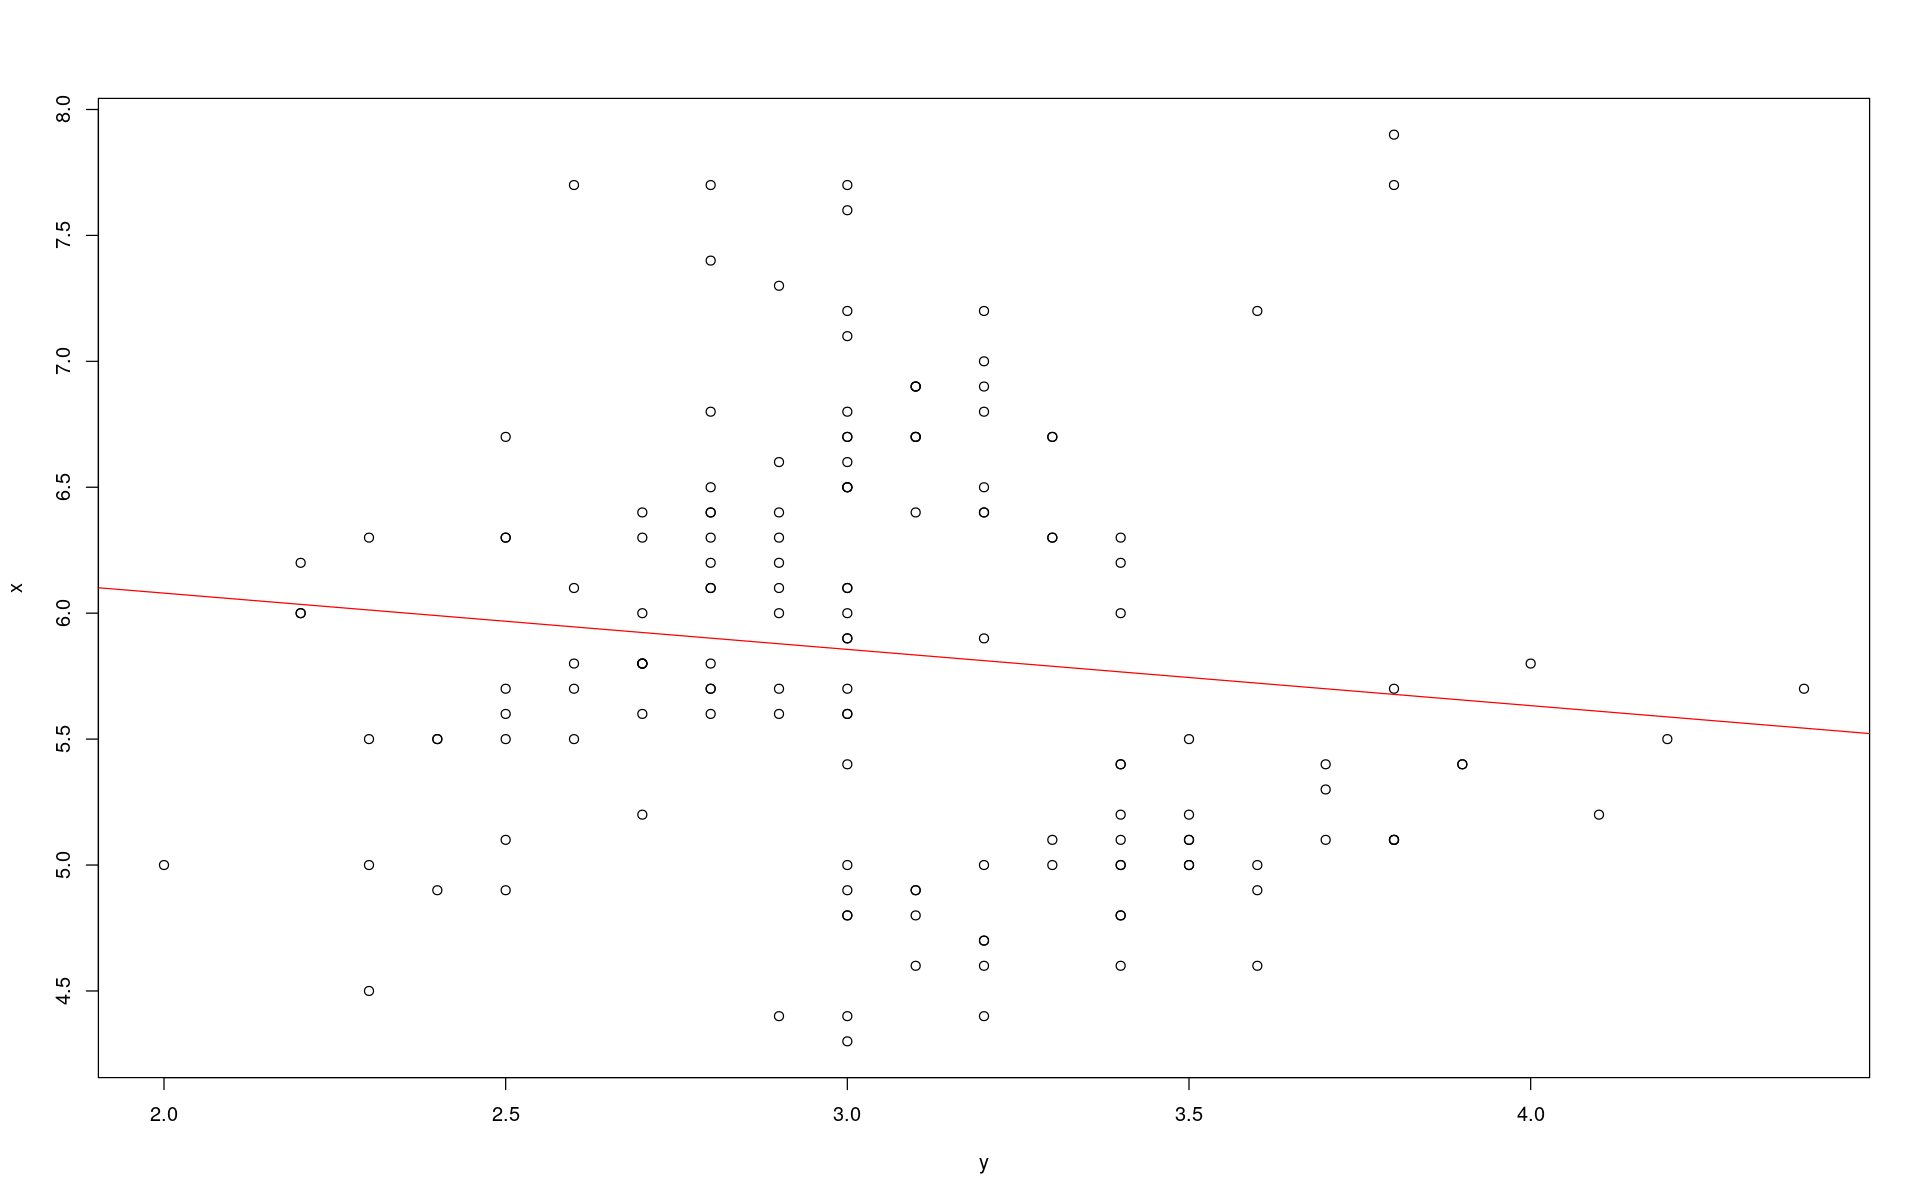

In [3]:
library(profvis)

# Profile the following code with the profvis function
profvis({
    dat <- data.frame(
        x = iris$Sepal.Length,
        y = iris$Sepal.Width
    )
    plot(x ~ y, data = dat)
    m <- lm(x ~ y, data = dat)
    abline(m, col = "red")
})

## Data Structure
When working with large data sets, choosing the right data structure can improve performance and memory efficiency. While base R provides useful data manipulation functions, `dplyr` and `data.table` offer optimized alternatives that are faster and more efficient, especially for large data sets.

In [5]:
library(dplyr)
library(data.table)
library(microbenchmark)

large_df <- data.frame(
  ID = 1:100000,
  Value = rnorm(100000),
  Category = sample(letters[1:5], 100000, replace = TRUE)
)

In [6]:
# Using base R
base_r_time <- microbenchmark(
  large_df[large_df$Category == "a", ], 
  unit = "ms"
)

# Using dplyr
dplyr_time <- microbenchmark(
  large_df %>% filter(Category == "a"), 
  unit = "ms"
)

# Using data.table
large_dt <- data.table(large_df)
data_table_time <- microbenchmark(
  large_dt[Category == "a"], 
  unit = "ms"
)

print(base_r_time)
print(dplyr_time)
print(data_table_time)

Unit: milliseconds
                                 expr      min       lq     mean  median
 large_df[large_df$Category == "a", ] 1.951186 2.015966 2.217771 2.09617
       uq      max neval
 2.180966 3.817482   100
Unit: milliseconds
                                 expr      min       lq     mean   median
 large_df %>% filter(Category == "a") 1.175072 1.199642 1.437117 1.224221
       uq      max neval
 1.653107 4.735144   100
Unit: milliseconds
                      expr      min        lq      mean    median       uq
 large_dt[Category == "a"] 0.623579 0.6398435 0.7609783 0.6527635 0.666734
      max neval
 6.502654   100


**Base R**: Can be efficient for small datasets, but lacks optimizations for large datasets. Each operation creates a copy of the dataset, leading to memory inefficiency.

**dplyr**: This is part of the tidyverse and uses efficient backends for performance gains. The pipe operator (`%>%`) allows chaining operations in a readable way. It provides a consistent set of verbs to help solve the most common data manipulation challenges (e.g. `mutate()`, `select()`, `summarise()`).

**data.table**: Provides an enhanced version of `data.frame` and is designed for big data processing in R. It uses in-place modifications to avoid memory overhead.

## Vectorization

Vectorization is a key technique to improve performance in R. Instead of using loops, use vectorized operations whenever possible.
Vectorizing refers to applying a function to a whole vector or array of data at once, rather than iterating through the elements one by one. R is designed to work with vectorized operations, which are inherently faster and more efficient than loops for many tasks (especially for larger datasets).

In [7]:
## Pre-allocation ##
# Memory is pre-allocated, preventing expensive resizing. 
# But looping is still inefficient since R has to access and modify each element one-by-one.

pre_allocate <- function(n){
    x <- vector("numeric", n) # Memory is pre-allocated
    for (i in 1:n)
        x[i] <- i
}

pre_allocate_time <- microbenchmark(pre_allocate(1000), unit = "ms")
print(pre_allocate_time)

Unit: milliseconds
               expr      min       lq       mean   median        uq      max
 pre_allocate(1000) 0.019992 0.020402 0.03856853 0.021492 0.0221695 1.729898
 neval
   100


In [8]:
## vectorized ##
# R internally allocates memory all at once, avoiding costly resizing

vectorized <- function(n){
    x <- 1:n # directly creates the entire vector in one step
}
vectorized_time <- microbenchmark(vectorized(1000), unit = "ms")
print(vectorized_time)

Unit: milliseconds
             expr     min       lq       mean   median        uq      max neval
 vectorized(1000) 0.00022 0.000224 0.01029565 0.000231 0.0002565 0.998413   100


In [9]:
## The worst !! ##
# At each iteration, more memory is requested, which can take hours to run if large vectors are created
# Every step, R creates a completely new vector. The old vector is copied into new memory, making this slower and slower as n increases.
# This can take hours if n is large!

growing_vector <- function(n){
    x <- NULL
    for (i in 1:n)
        x <- c(x,i) # Creates new vector at each step
}

growing_vector_time <- microbenchmark(growing_vector(1000), unit = "ms")
print(growing_vector_time)

Unit: milliseconds
                 expr      min        lq      mean   median       uq      max
 growing_vector(1000) 0.502181 0.5233325 0.6511391 0.530605 0.549353 4.085755
 neval
   100


#### Different Approaches
Different approaches for computing the mean of elements in a large list to demonstrate performance improvements through vectorization and alternative techniques.

In [10]:
## Setup ##

library(ggplot2)
library(microbenchmark)

# l <- list(-200000:-3, 4:800, c(3,1,660,28,9000), 1:20000, 50:100000, -700000:1, c(1,2))
# l <- list(1:5, c(3,1,66,2,90),-5:-1)
# l <- lapply(1:100000, function(x) rnorm(sample(1:100, 1))) # list with 100000 elements, where each element is a numeric vector of random length (between 1 and 100)
l = lapply(1:100000, \(x) rnorm(20))

**Loop**: Iterate through the list using a for loop, manually computing the mean for each element. 
Loops in R are inefficient because R is an interpreted language, not compiled.
Each iteration accesses list elements individually, creating a lot of overhead.

In [12]:
loop_means <- function(l) {
  result <- numeric(length(l))
  for (i in 1:length(l)) {
    result[i] <- mean(l[[i]])
  }
  return(result)
}

**sapply**: vectorized function that applies the mean function to each element of the list automatically. It's more concise and typically faster than the loop approach. It applies a function to a list or vector and simplifies the result to a vector or matrix.

In [15]:
sapply_means <- function(l) {
  sapply(l, mean)
}

**Vectorize**: creates a function wrapper that vectorizes the action of its argument FUN. It operates element-wise on a list.

**unlist**: combines lapply() (which applies mean efficiently) with unlist(), which flattens the result into a vector.

In [17]:
unlist_means <- function(l) {
  colMeans(matrix(unlist(l), ncol = length(l)))
}

In [20]:
timing = microbenchmark(
  loop = loop_means(l),
  sapp = sapply_means(l),
  unlist = unlist_means(l)
)

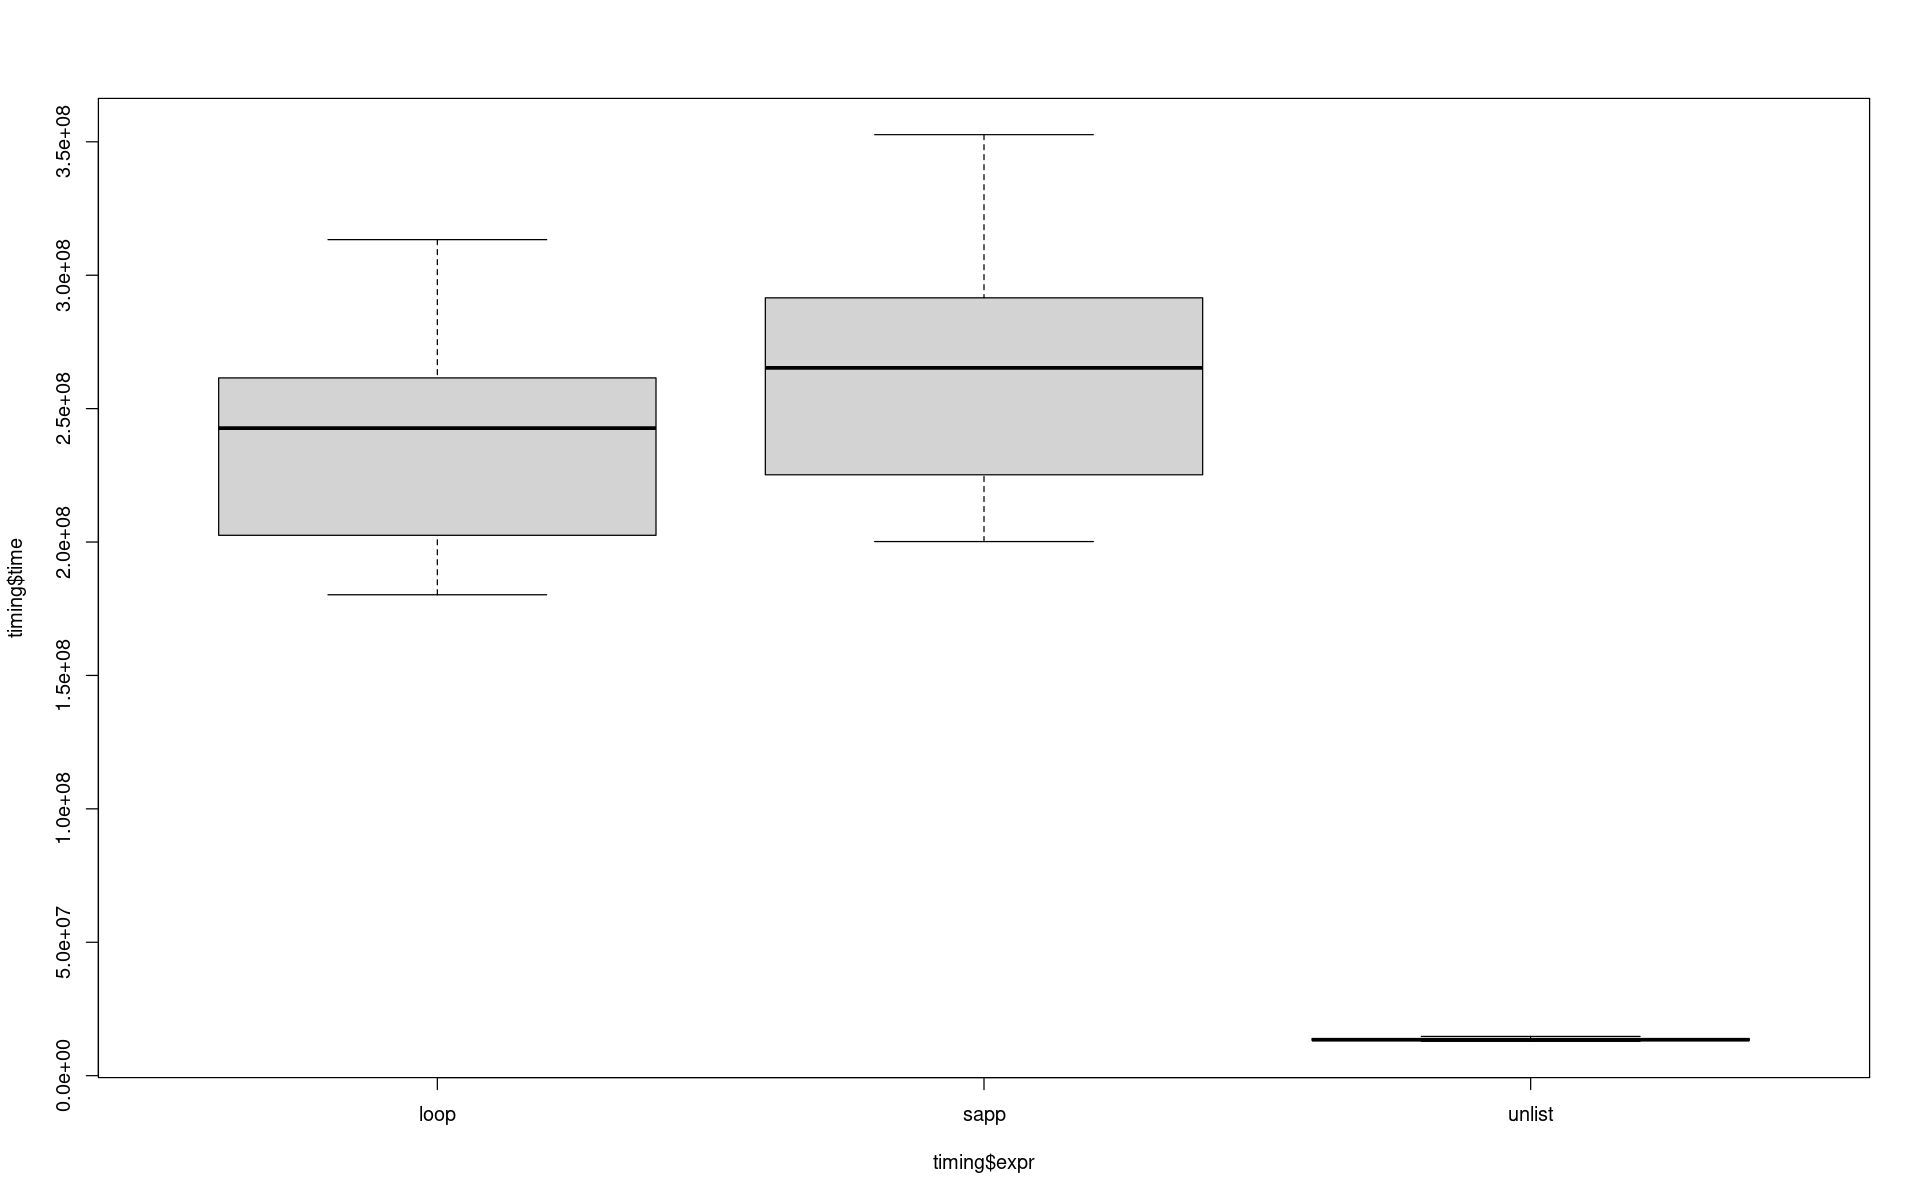

In [21]:
boxplot(timing$time ~ timing$expr, outline = F)

**Rcpp**: The function is rewritten in C++ using Rcpp, allowing it to run significantly faster by avoiding R's interpretation overhead. Orders of magnitude faster than loops or sapply() since it uses compiled C++ code.

## Identification of Bottlenecks

- Given a matrix `mat` with **100 observations (rows)** and **10 batches (columns)**.
- The goal is to remove the batch effect using linear regression.

In [22]:
## Setup ##

# Matrix with random values
mat <- matrix(rnorm(100 * 10, mean = 10, sd = 3), nrow = 100, ncol = 10)

# Batch variable (e.g., batch effect groups)
batch <- factor(rep(1:10, each = 10))  # 10 batches, each with 10 observations

In [23]:
mat <- t(mat)

# Pre-allocate results?
corrected <- matrix(0, nrow = nrow(mat), ncol = ncol(mat))
for (i in 1:nrow(mat)) {
  corrected[i,] <- lm(mat[i,] ~ batch)$residuals
}

# Extend e.g. list on the fly?
corrected <- list()
for (i in 1:nrow(mat)) {
  corrected[[i]] <- lm(mat[i,] ~ batch)$residuals
}
corrected = do.call(rbind, corrected)

When there is something else slowing your code:

In [24]:
library(RcppArmadillo)
corrected = matrix(0, nrow = nrow(mat), ncol = ncol(mat))
for (i in 1:nrow(mat)) {
  corrected[i,] <- RcppArmadillo::fastLm(mat[i,], batch)$residuals
}

## Memory Optimization

- Integers use less memory than doubles -> integer(), `1L` instead of numeric(), `1`
- Characters are big, save memory by using factors -> Factors are actually integers, each name only stored once
- Convert big matrices to Matrix::sparseMatrix() -> sparse_mat = as(mat, "sparseMatrix")
- Sometimes, the containing env is attached to an object. Check object size with pryr::object_size()

## Garbage Collection

- If a lot of memory is blocked after a big operation, use R’s garbage collection gc()
- If gc() doesn’t free (enough) memory, try mallinfo::malloc.trim() (https://github.com/Laurae2/mallinfo)

## Parallelization

By default, R runs operations single-threaded, meaning it uses only one CPU core.
When dealing with large datasets or intensive computations, using multiple CPU cores can significantly speed up execution.
The `parallel` package allows to distribute computations across multiple cores.

In [25]:
large_matrix <- matrix(rnorm(1e6), nrow = 10000, ncol = 100)

In [26]:
library(microbenchmark)
library(parallel)

# Single-threaded apply
apply_time <- microbenchmark(apply(large_matrix, 2, mean), times = 10)

# Multi-threaded parApply
n_cores <- detectCores() # determine number of cores in your machine
cl <- makeCluster(n_cores)  # create cluster
parapply_time <- microbenchmark(parApply(cl, large_matrix, 2, mean), times = 10)
stopCluster(cl) # stop cluster 

print(apply_time)
print(parapply_time)

Unit: milliseconds
                         expr      min       lq     mean   median       uq
 apply(large_matrix, 2, mean) 4.913414 4.935908 5.912048 5.142905 6.709444
      max neval
 9.116521    10
Unit: milliseconds
                                expr     min       lq     mean   median
 parApply(cl, large_matrix, 2, mean) 53.7636 60.82535 62.83235 62.11264
       uq     max neval
 66.14012 71.4116    10


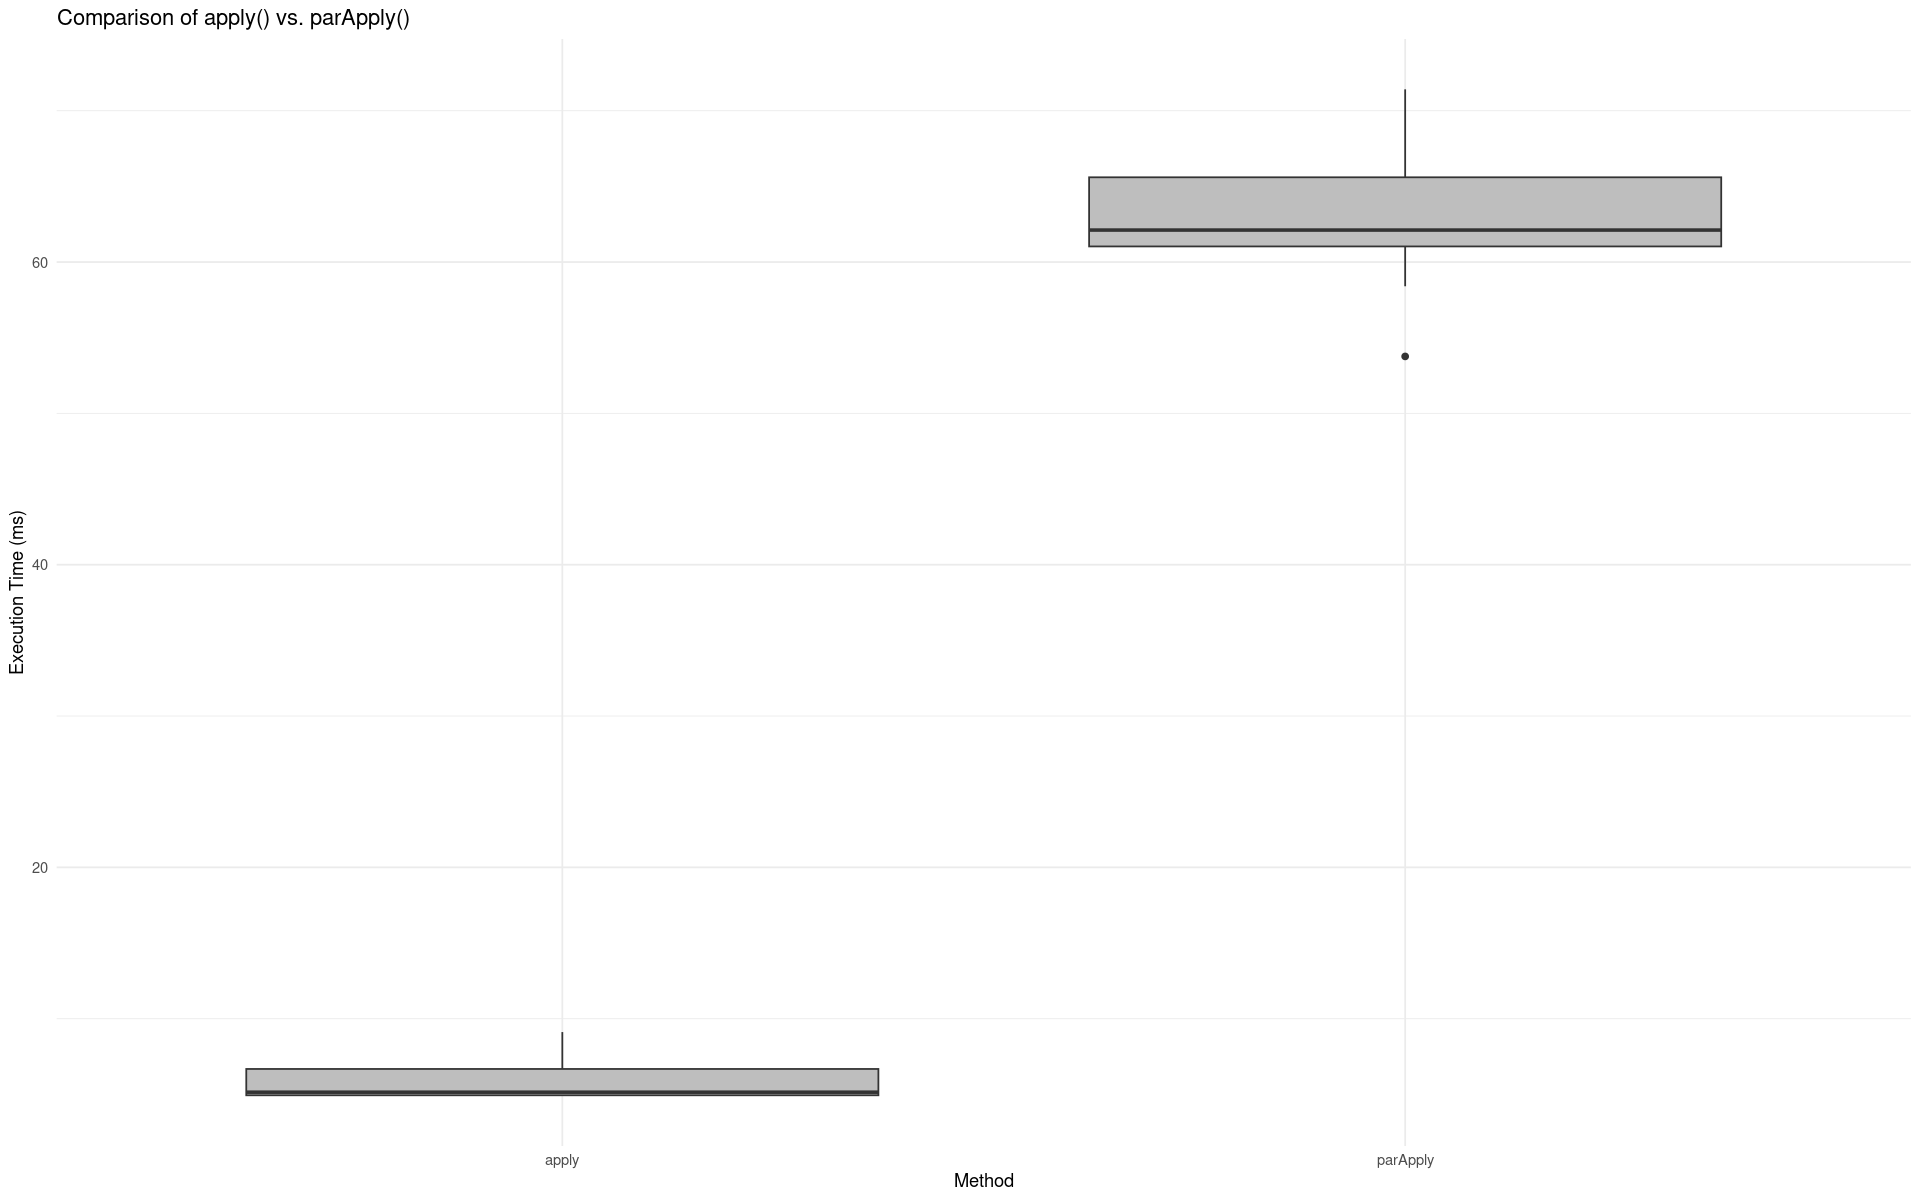

In [27]:
library(ggplot2)

times <- data.frame(
  Method = rep(c("apply", "parApply"), each = 10),
  Time = c(apply_time$time, parapply_time$time) / 1e6  # Convert to milliseconds
)

ggplot(times, aes(x = Method, y = Time)) +
  geom_boxplot(fill = "grey") +
  theme_minimal() +
  labs(y = "Execution Time (ms)", title = "Comparison of apply() vs. parApply()") +
  theme(legend.position = "none") +
  theme(axis.title = element_text(size = 18),
        axis.text = element_text(size = 11),
        plot.title = element_text(size = 20, face = "bold", hjust = 0.5))

In [28]:
# Runs single-threaded (uses only one CPU core
means = apply(iris[,1:4], 2, mean)
print(means)

Sepal.Length  Sepal.Width Petal.Length  Petal.Width 
    5.843333     3.057333     3.758000     1.199333 


In [29]:
# Runs operations in parallel using multiple CPU cores

library("parallel")

n_cores <- detectCores() # determine number of cores in your machine

cl = makeCluster(n_cores) # create cluster
means = parApply(cl, iris[,1:4], 2, mean) 
stopCluster(cl) # stop cluster

print(means)

Sepal.Length  Sepal.Width Petal.Length  Petal.Width 
    5.843333     3.057333     3.758000     1.199333 


## Hash Sets and Hash Maps
- Hash sets and [hash maps](https://en.wikipedia.org/wiki/Hash_table) are data structures commonly used in programming. They are a bit similar to (named-) lists, but they can perform certain operations much faster.
- Implementation of hash sets/maps is unfortunatelly not directly available in the base R, but they can be used via the package [r2r](https://cran.r-project.org/web/packages/r2r/index.html) (under the hood, the package rellies on the usage of R [environments](https://adv-r.hadley.nz/environments.html)).
- Hash sets behaves the same way as [sets](https://en.wikipedia.org/wiki/Set_(mathematics)) in the mathematical sense. This differ from the way how lists operate:
    - Each element can be included in the set at most once.
    - Sets are not ordered.
- Hash maps works similarly as named lists in R, but the keys (names) can be arbitrary objects instead of just strings. Also, the time complexity of using a key to access a value is a constant instead of a linear time.

### Hashing allows access in constant time
- Starting with R lists and vectors: the good thing is that they allow constant time $\mathcal{O}(1)$ access to their elements, if we use the integer index.

In [30]:
small_list = as.list(1:10) # The elements of the list can be anything, we just use numbers here for simplicity
very_large_list = as.list(1:10^6)

bench_read_1 <- microbenchmark(x <- small_list[[7]])
bench_read_2 <- microbenchmark(x <- very_large_list[[456789]])

print(bench_read_1)
print(bench_read_2)

Unit: nanoseconds
                 expr min lq   mean median  uq  max neval
 x <- small_list[[7]]  96 99 159.01    100 101 5398   100
Unit: nanoseconds
                           expr min  lq   mean median  uq  max neval
 x <- very_large_list[[456789]]  99 100 132.76    101 102 2944   100


- So far so good: accessing elements in the lists took about same time for both small and large list. Also, the operation is super fast in general, as it took only about 150 nanoseconds.
- However, things get worse if we want to check for presence of certain object (number, string...) in the list, using the **%in%** operator. The R simply tries to compare the object to every element in the list. If the list get larger, then there will be (in the worst case, or on average) more comparisons needed to be made. This is a linear time $\mathcal{O}(n)$ operation.

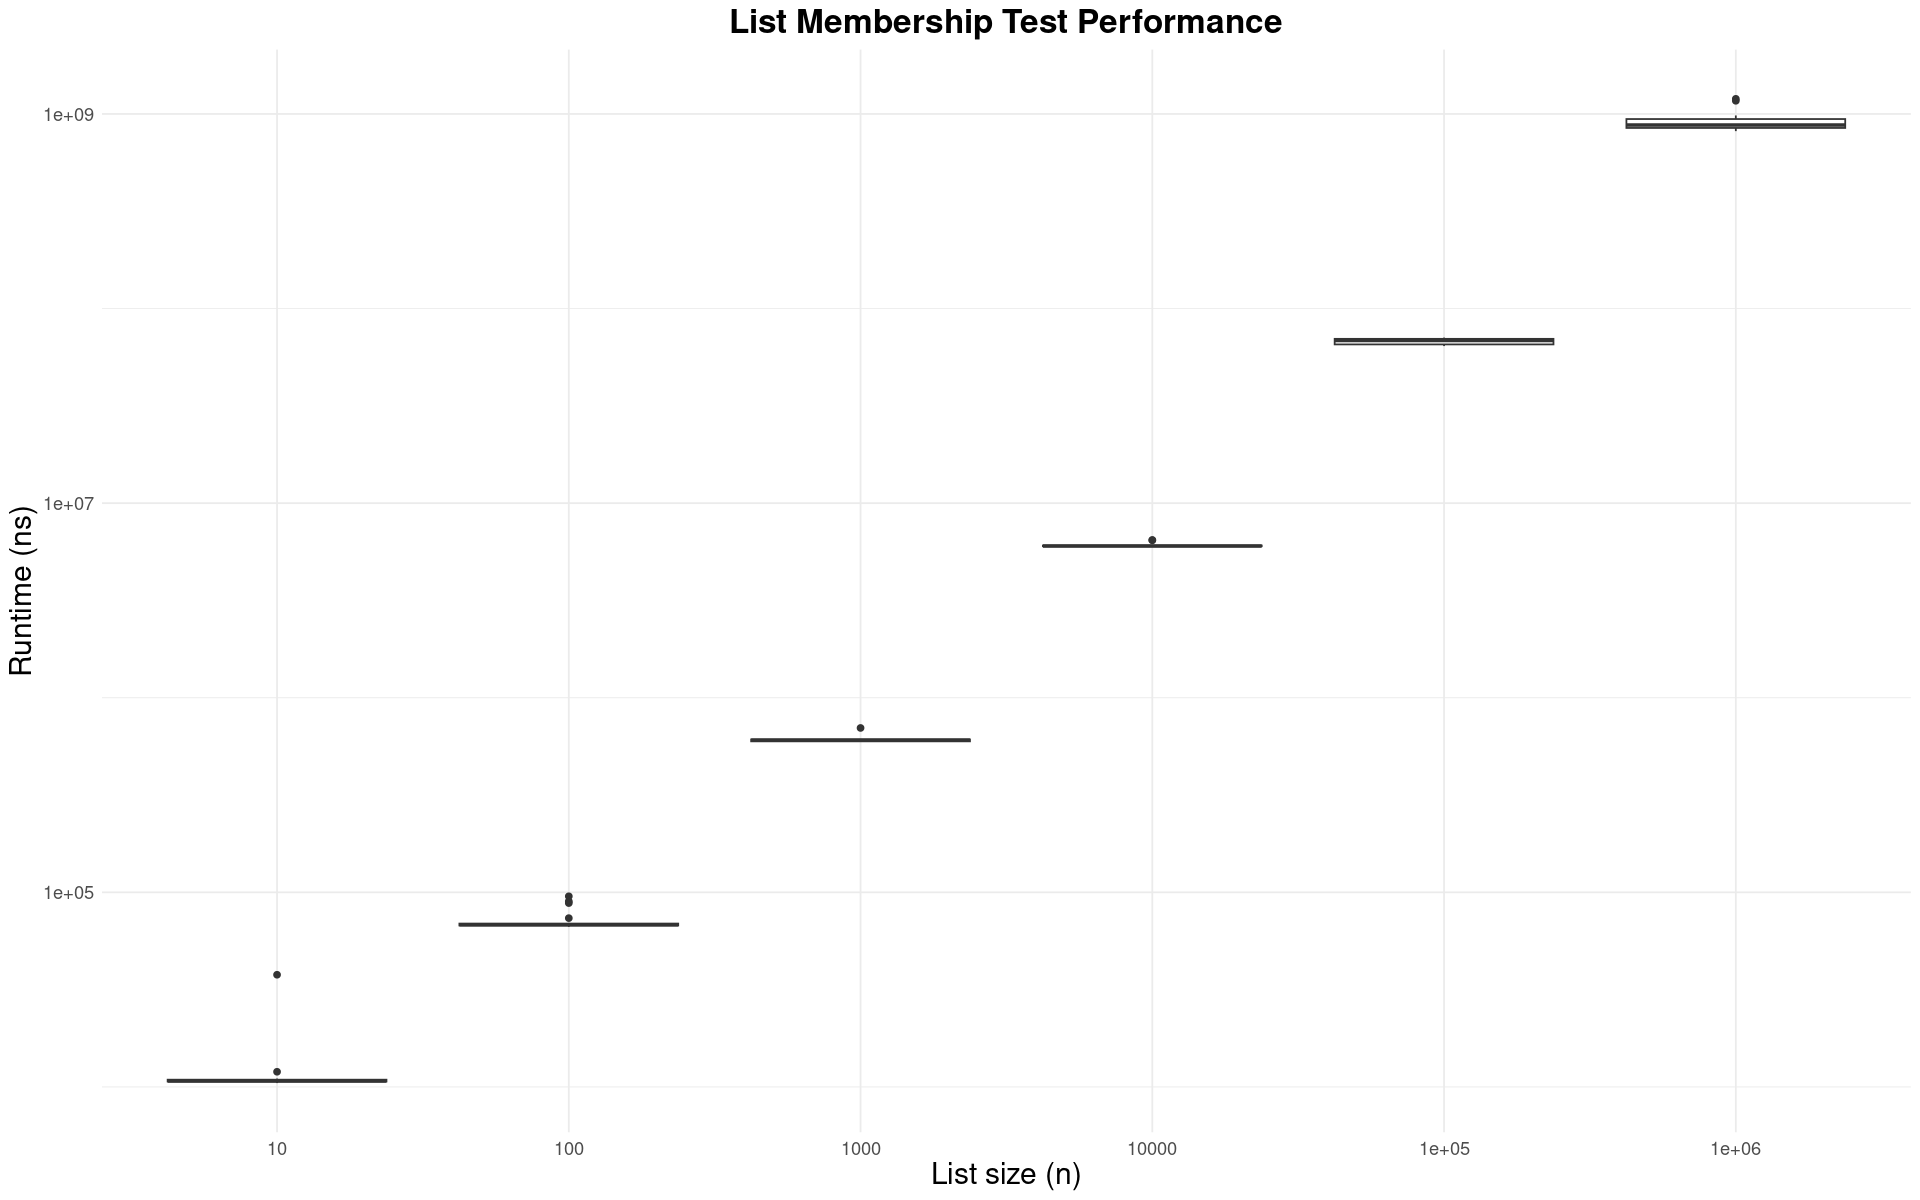

In [31]:
list_sizes <- 10^(1:6)
results <- data.frame(n = character(), time = numeric())

for (n in list_sizes) {    
    tested_list <- as.list(sample(1:n, n, replace = TRUE))    
    bench_read <- microbenchmark(is_included <- sample(1:n, 1) %in% tested_list, unit = "ns", times=20)     
    results <- rbind(results, data.frame(n = as.character(n), time = bench_read$time))
}

ggplot(results, aes(x = n, y = time)) +
    geom_boxplot() +
    scale_y_log10() +
    labs(x = "List size (n)", y = "Runtime (ns)", title = "List Membership Test Performance") +
    theme_minimal() +
    theme(axis.title = element_text(size = 18),
        axis.text = element_text(size = 11),
        plot.title = element_text(size = 20, face = "bold", hjust = 0.5))

- The [hashing](https://en.wikipedia.org/wiki/Hash_function) works the same way as accessing a list by integer index - the hash of the object specify a place in memory where the object should be located. R can go directly to that place, without iterating over all elements in the set. Accesing the element in hash set is therefore constant time $\mathcal{O}(1)$ operation.

Doing the same using hashsets:

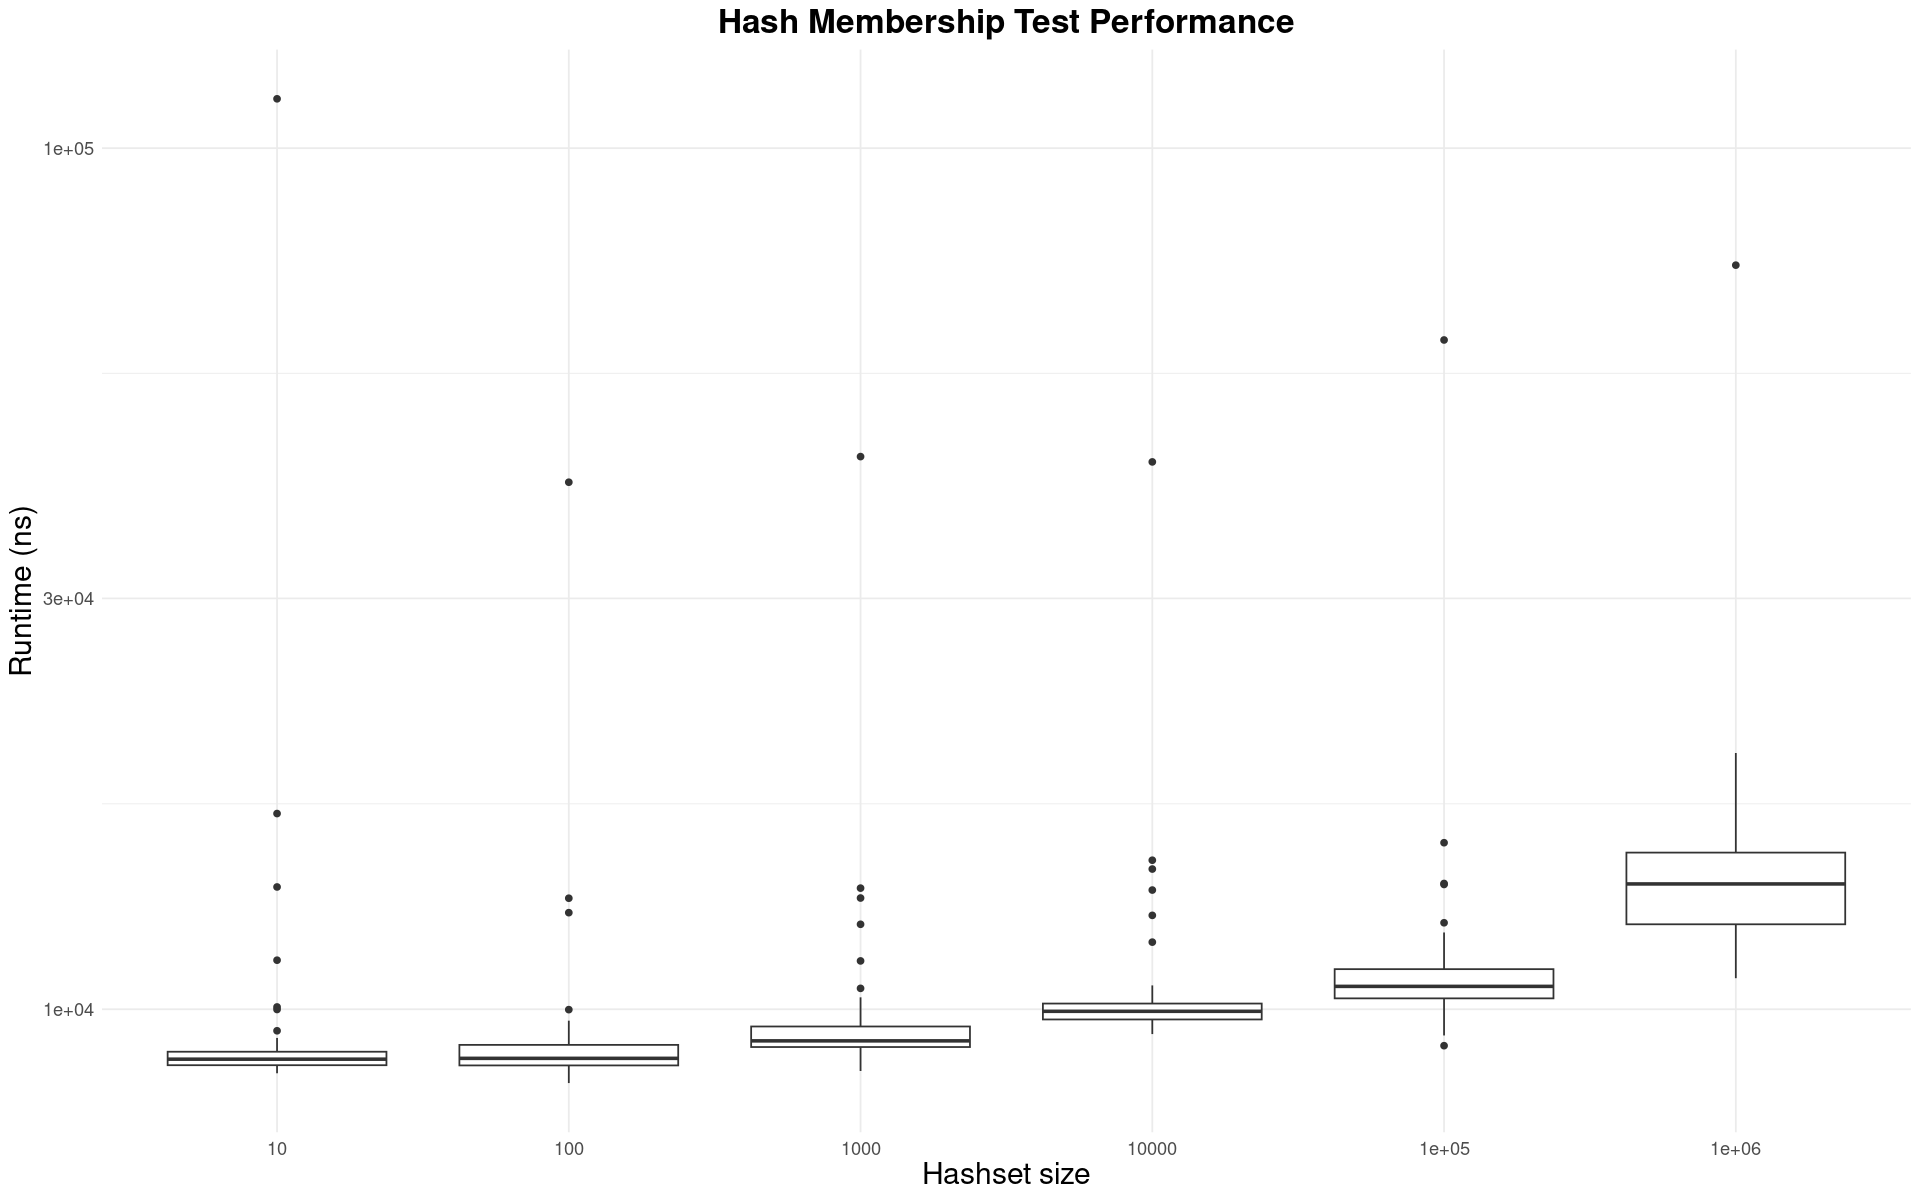

In [32]:
library(r2r)

set_sizes <- 10^(1:6)
results <- data.frame(n = character(), time = numeric())

for (n in set_sizes) {
    tested_hashset <- do.call(hashset, as.list(sample(1:n, n))) 
    bench_read <- microbenchmark(is_included <- tested_hashset[[sample(1:n, 1)]], unit = "ns", times=100)     
    results <- rbind(results, data.frame(n = as.character(n), time = bench_read$time))
}

ggplot(results, aes(x = n, y = time)) +
    geom_boxplot() +
    scale_y_log10() +
    labs(x = "Hashset size", y = "Runtime (ns)", title = "Hash Membership Test Performance") +
    theme_minimal() +
    theme(axis.title = element_text(size = 18),
        axis.text = element_text(size = 11),
        plot.title = element_text(size = 20, face = "bold", hjust = 0.5))

- The [hashing](https://en.wikipedia.org/wiki/Hash_function) works the same way as accessing a list by integer index - the hash of the object specify a place in memory where the object should be located. R can go directly to that place, without iterating over all elements in the set. Accesing the element in hash set is therefore constant time $\mathcal{O}(1)$ operation.